# Mediacloud url prep:

**Tasks**:
- Find media ID from source name
- Count number of articles per source
- Get Mediacloud urls
    - Query from API and save as a csv
    - Create dataframe from API data
    - Filter out stories that are duplicated and/or dont have date info
- Check min and max dates retrieved
- Calculate differences between expected stories (storyCount) and stories actually retrieved (storyList)


**References**:
- [Media Cloud Tutorials](https://github.com/mediacloud/api-tutorial-notebooks)
- [Wai Lam's US right media](https://github.com/wlmwng/us-right-media/blob/develop/usrightmedia/code/03-mediacloud/01-mediacloud-prep-urls.ipynb)

In [231]:
from dotenv import load_dotenv
import os, mediacloud.api
import datetime
import json
import pandas as pd 
from IPython.display import JSON
import mediacloud.tags
import csv
from tqdm import tqdm
import requests

In [291]:
# Setting up
mc = mediacloud.api.MediaCloud('fe45b5cd600102ff0ff5e5a8185c4dabbbae2a9335942558067a470ab77ac9cf')
mediacloud.__version__

'3.12.5'

In [292]:
mc.stats()

{'active_crawled_feeds': 164386,
 'active_crawled_media': 58507,
 'daily_downloads': 1507552,
 'daily_stories': 1020235,
 'mediacloud_stats_id': 12,
 'stats_date': '2022-04-17',
 'total_downloads': 0,
 'total_sentences': 0,
 'total_stories': 0}

### Sources and Collections

In [293]:
# Find media ID from source name
matching_sources = mc.mediaList(name_like='New York Times', sort='num_stories') 
JSON(matching_sources)
[m['media_id'] for m in matching_sources]

[1, 1363090]

### Counting stories

In [294]:
# Set date range
start_date = datetime.date(2013,1,1)
end_date = datetime.date(2022,3,30)
date_range = mc.dates_as_query_clause(start_date, end_date) # default is start & end inclusive

In [295]:
# Right-wing media mentioning voter ID
q_right = '("voter ID" or "voter identification" or "ID law" or "ID laws" or "voting ID") and (media_id:1092 OR media_id:6443 OR media_id:101 OR media_id:7 OR media_id:19334 OR media_id:1150 OR media_id:18775 OR media_id:25649 OR media_id:1117)'
count_r = mc.storyCount(q_right, date_range)
# check how many left-wing media mention voter ID
q_left = '("voter ID" or "voter identification" or "ID law" or "ID laws" or "voting ID") and (media_id:2 OR media_id:1 OR media_id:1149 OR media_id:1095 OR media_id:25499 OR media_id:4 OR media_id:104828 OR media_id:9 OR media_id:27502)'
count_l = mc.storyCount(q_left, date_range)
# total number of stories
query = '("voter ID" or "voter identification" or "ID law" or "ID laws" or "voting ID") and (media_id:2 OR media_id:1 OR media_id:1149 OR media_id:1095 OR media_id:25499 OR media_id:4 OR media_id:104828 OR media_id:9 OR media_id:27502 OR media_id:1092 OR media_id:6443 OR media_id:101 OR media_id:7 OR media_id:19334 OR media_id:1150 OR media_id:18775 OR media_id:25649 OR media_id:1117)'
count_q = mc.storyCount(query, date_range)

print(count_r, count_l, count_q)

{'count': 3192} {'count': 5026} {'count': 8315}


In [296]:
# create function simplifying storyCount request
def get_outlet_story_count(media_id):
    story_count = mc.storyCount(f'("voter ID" or "voter identification" or "ID law" or "ID laws" or "voting ID") and (media_id:{media_id})', date_range)
    return story_count

In [299]:
# Find storyCount of sources
sources = [2, 1, 1149, 1095, 25499, 4, 104828, 9, 27502, 1092, 6443, 101, 7, 19334, 1150, 18775, 25649, 1117]
results = []
for x in sources:
    story_counts = get_outlet_story_count(x)['count']
    results.append(story_counts)
print(results)

[1259, 686, 584, 471, 286, 305, 267, 117, 1051, 631, 147, 1052, 134, 518, 175, 288, 94, 154]


In [369]:
names = ['Washington Post', 'New York Times', 'MSNBC', 'CNN', 'NBC News', 'USA Today', 'Vox', 'Chicago Tribune', 'HuffPost', 'Fox News', 'Washington Examiner', 'Washington Times', 'New York Post', 'Breitbart', 'Wall Street Journal', 'Daily Caller', 'Free Beacon', 'National Review']

a=list(zip(names, results))
stories = pd.DataFrame(a, columns=['media_name', 'story_count'])
stories

,media_name,story_count
0,Washington Post,1259
1,New York Times,686
2,MSNBC,584
3,CNN,471
4,NBC News,286
5,USA Today,305
6,Vox,267
7,Chicago Tribune,117
8,HuffPost,1051
9,Fox News,631


In [301]:
# total stories to collect
stories['story_count'].sum()

8219

### Getting stories

In [302]:
# This code snippet pages through all the stories in a query.
def all_matching_stories(mc_client, q, fq):
    """
    Return all the stories matching a query within Media Cloud. Page through the results automatically.
    :param mc_client: a `mediacloud.api.MediaCloud` object instantiated with your API key already
    :param q: your boolean query
    :param fq: your date range query
    :return: a list of media cloud story items
    """
    last_id = 0
    more_stories = True
    stories = []
    while more_stories:
        page = mc_client.storyList(q, fq, last_processed_stories_id=last_id, rows=500, sort='processed_stories_id')
        print("  got one page with {} stories".format(len(page)))
        if len(page) == 0:
            more_stories = False
        else:
            stories += page
            last_id = page[-1]['processed_stories_id']
    return stories

In [303]:
# let's fetch all the stories matching our query (8850 stories)
story_data = all_matching_stories(mc, query, date_range)
len(story_data)

  got one page with 148 stories
  got one page with 358 stories
  got one page with 328 stories
  got one page with 290 stories
  got one page with 248 stories
  got one page with 237 stories
  got one page with 42 stories
  got one page with 24 stories
  got one page with 40 stories
  got one page with 434 stories
  got one page with 338 stories
  got one page with 74 stories
  got one page with 443 stories
  got one page with 500 stories
  got one page with 500 stories
  got one page with 500 stories
  got one page with 255 stories
  got one page with 0 stories


4759

Writing and saving a CSV of Story Data

In [304]:
# first flatten things a little bit to make writing a CSV easier
for s in story_data:
    theme_tag_names = ','.join([t['tag'] for t in s['story_tags'] if t['tag_sets_id'] == mediacloud.tags.TAG_SET_NYT_THEMES])
    s['themes'] = theme_tag_names
# now write the CSV
fieldnames = ['stories_id', 'publish_date', 'title', 'url', 'language', 'ap_syndicated', 'themes', 'media_id', 'media_name', 'media_url']
with open('mediacloud-urls.csv', 'w', newline='', encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, extrasaction='ignore')
    writer.writeheader()
    for s in story_data:
        writer.writerow(s)

In [305]:
# Create dataframe from saved csv file
corpus = pd.read_csv('mediacloud-urls.csv', encoding="utf-8")
len(corpus) # check number of urls
corpus.head()

,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url
0,318516682,2015-02-13 15:13:13,Republicans are pledging to win more of the bl...,http://feeds.voices.washingtonpost.com/c/34656...,en,False,NaN,2,Washington Post,http://washingtonpost.com
1,318811193,2015-02-13 11:42:46,Elisabeth MacNamara: 6 Ways the League of Wom...,http://www.huffingtonpost.com/elisabeth-macnam...,en,False,NaN,27502,HuffPost,http://www.huffingtonpost.com/#
2,319094668,2015-02-10 04:55:04,Robert M. Brandon: Opportunities for Effectiv...,http://www.huffingtonpost.com/robert-m-brandon...,en,False,NaN,27502,HuffPost,http://www.huffingtonpost.com/#
3,320942194,2015-02-22 11:42:46,Mary Bottari: Scott Walker Pushes ALEC 'Right...,http://www.huffingtonpost.com/mary-bottari/sco...,en,False,NaN,27502,HuffPost,http://www.huffingtonpost.com/#
4,321743370,2015-02-25 09:03:01,Ted Strickland Announces He's Running For The ...,http://www.huffingtonpost.com/2015/02/25/ted-s...,en,False,NaN,27502,HuffPost,http://www.huffingtonpost.com/#


In [335]:
domain = corpus['media_id'].value_counts()  #counting urls per news media source
pd.DataFrame(domain)

,media_id
2,600
101,543
27502,518
1092,505
1149,399
19334,373
1095,323
1,316
4,220
18775,211


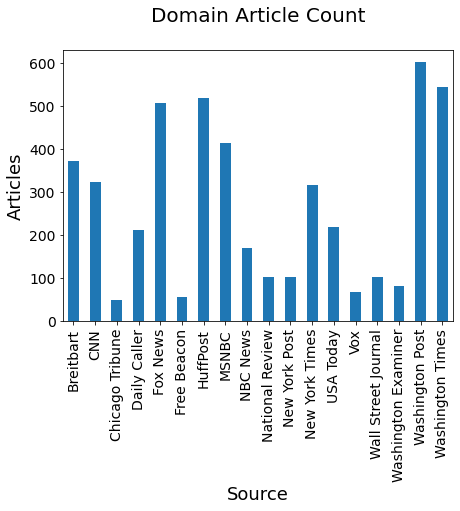

In [307]:
# Displaying number of urls retrieved per source
ax = domain.sort_index().plot(kind='bar', fontsize=14, figsize=(7,5)) 
ax.set_title('Domain Article Count\n', fontsize=20)
ax.set_xlabel('Source', fontsize=18)
ax.set_ylabel('Articles', fontsize=18);

In [1]:
# create list of urls from pandas dataframe
urls = corpus['url'].to_list()

NameError: name 'corpus' is not defined

### Removing duplicates or articles without date

In [309]:
# Find and remove duplicates or articles without a date
corpus['exclude_dupe'] = corpus.duplicated(subset=['title', 'url'])
corpus['exclude_no_date'] = corpus['publish_date'].isna()
corpus = corpus.loc[(~corpus['exclude_dupe']) & (~corpus['exclude_no_date'])]
len(corpus)

4730

### Converting publish_date to datetime

In [264]:
# checking data type for publish_date variable
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4759 entries, 0 to 4758
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   stories_id     4759 non-null   int64 
 1   publish_date   4733 non-null   object
 2   title          4759 non-null   object
 3   url            4759 non-null   object
 4   language       4758 non-null   object
 5   ap_syndicated  4759 non-null   bool  
 6   themes         900 non-null    object
 7   media_id       4759 non-null   int64 
 8   media_name     4759 non-null   object
 9   media_url      4759 non-null   object
dtypes: bool(1), int64(2), object(7)
memory usage: 339.4+ KB


In [340]:
# left_corpus.rename(columns={'publish_date': 'Date'}) #renaming date column
corpus['Date'] = pd.to_datetime(corpus['publish_date']) # converting publish_date to datetime
corpus['mnth_yr'] = corpus['Date'].apply(lambda x: x.strftime('%d %B, %Y')) # converting datetime to string with format: day, month, year
corpus['Date'] = pd.to_datetime(corpus['mnth_yr']) # converting string to simplified datetime column
corpus.head()

,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url,exclude_dupe,exclude_no_date,Date,mnth_yr
0,318516682,2015-02-13 15:13:13,Republicans are pledging to win more of the bl...,http://feeds.voices.washingtonpost.com/c/34656...,en,False,NaN,2,Washington Post,http://washingtonpost.com,False,False,2015-02-13,"13 February, 2015"
1,318811193,2015-02-13 11:42:46,Elisabeth MacNamara: 6 Ways the League of Wom...,http://www.huffingtonpost.com/elisabeth-macnam...,en,False,NaN,27502,HuffPost,http://www.huffingtonpost.com/#,False,False,2015-02-13,"13 February, 2015"
2,319094668,2015-02-10 04:55:04,Robert M. Brandon: Opportunities for Effectiv...,http://www.huffingtonpost.com/robert-m-brandon...,en,False,NaN,27502,HuffPost,http://www.huffingtonpost.com/#,False,False,2015-02-10,"10 February, 2015"
3,320942194,2015-02-22 11:42:46,Mary Bottari: Scott Walker Pushes ALEC 'Right...,http://www.huffingtonpost.com/mary-bottari/sco...,en,False,NaN,27502,HuffPost,http://www.huffingtonpost.com/#,False,False,2015-02-22,"22 February, 2015"
4,321743370,2015-02-25 09:03:01,Ted Strickland Announces He's Running For The ...,http://www.huffingtonpost.com/2015/02/25/ted-s...,en,False,NaN,27502,HuffPost,http://www.huffingtonpost.com/#,False,False,2015-02-25,"25 February, 2015"


### Checking differences between storycount and retrieved count

In [368]:
# count number of stories retrieved per outlet
df_count = pd.DataFrame(corpus.value_counts('media_name')).reset_index().rename(columns={0:'retrieved_count'})
df_count

,media_name,retrieved_count
0,Washington Post,600
1,Washington Times,543
2,HuffPost,518
3,Fox News,505
4,MSNBC,399
5,Breitbart,373
6,CNN,323
7,New York Times,316
8,USA Today,220
9,Daily Caller,211


In [353]:
# modify data type
df_count['media_id'] = df_count['media_id'].astype('str')
stories['media_id'] = stories['media_id'].astype('str')

In [370]:
# merge the story count dataframe with the retrieved count dataframe
df_outlets = stories.merge(df_count, on='media_name')
df_outlets

,media_name,story_count,retrieved_count
0,Washington Post,1259,600
1,New York Times,686,316
2,MSNBC,584,399
3,CNN,471,323
4,NBC News,286,163
5,USA Today,305,220
6,Vox,267,68
7,Chicago Tribune,117,49
8,HuffPost,1051,518
9,Fox News,631,505


In [371]:
df_outlets['exp_ret_diff_count'] = df_outlets['retrieved_count'] - df_outlets['story_count']
df_outlets['retrieved_pct'] = round(df_outlets['retrieved_count']/df_outlets['story_count']*100,2)
df_outlets

,media_name,story_count,retrieved_count,exp_ret_diff_count,retrieved_pct
0,Washington Post,1259,600,-659,47.66
1,New York Times,686,316,-370,46.06
2,MSNBC,584,399,-185,68.32
3,CNN,471,323,-148,68.58
4,NBC News,286,163,-123,56.99
5,USA Today,305,220,-85,72.13
6,Vox,267,68,-199,25.47
7,Chicago Tribune,117,49,-68,41.88
8,HuffPost,1051,518,-533,49.29
9,Fox News,631,505,-126,80.03


In [378]:
df_dates = corpus.groupby('media_name').agg({'Date': ['min', 'max']}).reset_index()
df_dates.columns = df_dates.columns.to_flat_index()
df_dates = df_dates.rename(columns={df_dates.columns[0]: "media_name",
                                      df_dates.columns[1]: "min_retrieved_date",
                                      df_dates.columns[2]: "max_retrieved_date"})

In [379]:
df_outlets = df_outlets.merge(df_dates, on='media_name')
df_outlets

,media_name,story_count,retrieved_count,exp_ret_diff_count,retrieved_pct,min_retrieved_date_x,max_retrieved_date_x,min_retrieved_date_y,max_retrieved_date_y
0,Washington Post,1259,600,-659,47.66,2013-01-13,2022-03-18,2013-01-13,2022-03-18
1,New York Times,686,316,-370,46.06,2013-02-18,2022-03-09,2013-02-18,2022-03-09
2,MSNBC,584,399,-185,68.32,2013-04-01,2022-03-21,2013-04-01,2022-03-21
3,CNN,471,323,-148,68.58,2013-01-18,2022-03-22,2013-01-18,2022-03-22
4,NBC News,286,163,-123,56.99,2013-05-20,2022-03-21,2013-05-20,2022-03-21
5,USA Today,305,220,-85,72.13,2013-03-03,2021-09-14,2013-03-03,2021-09-14
6,Vox,267,68,-199,25.47,2014-10-20,2022-03-16,2014-10-20,2022-03-16
7,Chicago Tribune,117,49,-68,41.88,2013-11-04,2021-06-17,2013-11-04,2021-06-17
8,HuffPost,1051,518,-533,49.29,2013-02-08,2022-02-10,2013-02-08,2022-02-10
9,Fox News,631,505,-126,80.03,2013-06-25,2022-03-30,2013-06-25,2022-03-30
